In [1]:
import cv2                                
import numpy as np                        
import matplotlib.pyplot as plt           
import pyrealsense2 as rs       

In [2]:
# Setup:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file("bag_abdias/prueba.bag")
profile = pipe.start(cfg)

# Skip 5 first frames to give the Auto-Exposure time to adjust
for x in range(5):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Capturados")

Frames Capturados


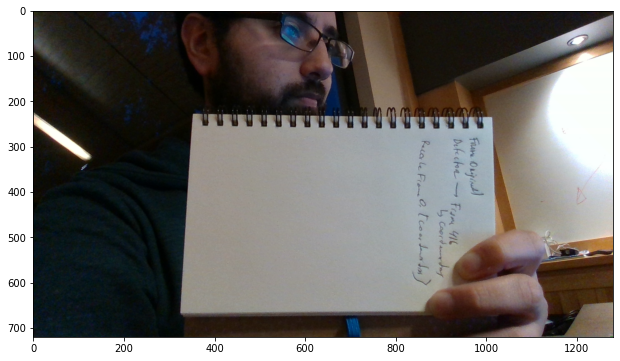

In [13]:
color = np.asanyarray(color_frame.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(color)

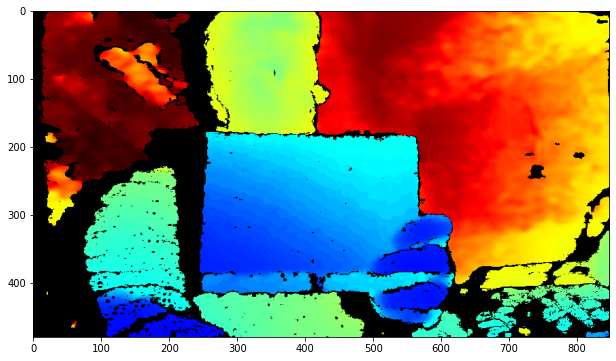

In [14]:
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(colorized_depth)

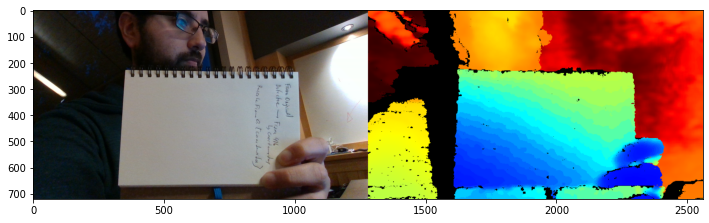

In [15]:
# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

# Show the two frames together:
images = np.hstack((color, colorized_depth))
plt.imshow(images)

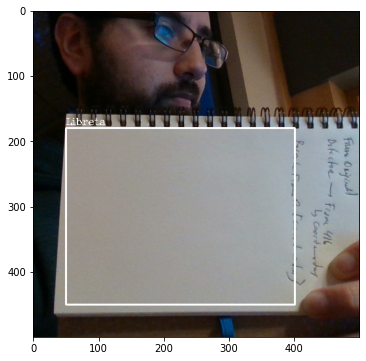

In [17]:
# Standard OpenCV boilerplate for running the net:
height, width = color.shape[:2]
expected = 500
aspect = width / height
resized_image = cv2.resize(color, (round(expected * aspect), expected))
crop_start = round(expected * (aspect - 1) / 2)
crop_img = resized_image[0:expected, crop_start:crop_start+expected]


conf  = 99
xmin  = 50
ymin  = 180
xmax  = 400
ymax  = 450

className = "Libreta"

cv2.rectangle(crop_img, (int(xmin), int(ymin)), 
             (int(xmax), int(ymax)), (255, 255, 255), 2)
cv2.putText(crop_img, className, 
            (int(xmin), int(ymin) - 5),
            cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,255,255))

plt.imshow(crop_img)

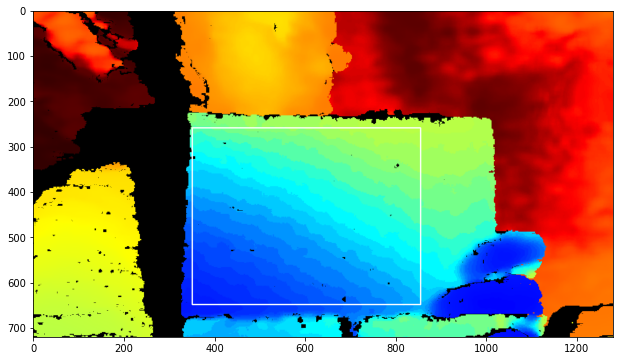

In [20]:
scale = height / expected
xmin_depth = int((xmin + crop_start) * scale)
ymin_depth = int((ymin) * scale)
xmax_depth = int((xmax + crop_start) * scale)
ymax_depth = int((ymax) * scale)
xmin_depth,ymin_depth,xmax_depth,ymax_depth
cv2.rectangle(colorized_depth, (xmin_depth, ymin_depth), 
             (xmax_depth, ymax_depth), (255, 255, 255), 2)
plt.imshow(colorized_depth)

In [21]:
depth = np.asanyarray(aligned_depth_frame.get_data())
# Crop depth data:
depth = depth[xmin_depth:xmax_depth,ymin_depth:ymax_depth].astype(float)

# Get data scale from the device and convert to meters
depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
depth = depth * depth_scale
dist,_,_,_ = cv2.mean(depth)
print("Se detecto un {0} {1:.3} metros de distancia.".format("objeto", dist))

Se detecto un objeto 0.187 metros de distancia.
